## 1. Introduction

### Project Title: Attention U-Net for ROI Analysis

#### Advanced Breast Cancer Segmentation with DSU-Net

---

### Problem Statement

Breast cancer is a leading cause of cancer-related deaths in women worldwide. Early and accurate diagnosis is critical for improving patient outcomes. The manual segmentation of suspicious regions (like masses or calcifications) in mammograms by radiologists is a time-consuming, subjective, and labor-intensive process. Automating this task can lead to faster, more objective, and potentially more accurate diagnoses.

---

### Project Goal

The goal of this project is to develop and train a state-of-the-art deep learning model — **DSU-Net (Dense Skip U-Net with Attention)** — to automatically and accurately segment Regions of Interest (ROI) in the public **CBIS-DDSM mammography dataset**.  
This project serves as a comprehensive, professional workflow for a computer-aided diagnosis (CAD) tool, from data analysis to final model evaluation.

---

### Methodology Overview

- **Exploratory Data Analysis (EDA):** Investigate the dataset's metadata to understand its composition and distributions.  
- **Data Preprocessing:** Create a unified master file linking images to masks and establish a robust data pipeline.  
- **Leak-Proof Splitting:** Implement a patient-aware strategy for splitting data to prevent data leakage and ensure a reliable evaluation.  
- **Advanced Model Architecture:** Build and implement a custom DSU-Net architecture from scratch in PyTorch, incorporating Attention Gates and Dense Blocks.  
- **State-of-the-Art Training:** Define and implement a sophisticated training regimen using a combined loss function (Dice + Focal + BCE), learning rate scheduling, and early stopping.  
- **Evaluation:** Train the model, evaluate its performance using Dice and IoU metrics, and perform a qualitative analysis by visualizing its predictions.


## 2. Environment Setup

In [1]:
# Step 2.1: Install Required Libraries
print("Installing required libraries...")

# Install the standard Python libraries
!pip install -q segmentation_models_pytorch
!pip install -q albumentations

# Install the problematic library from a pre-compiled wheel file hosted on GitHub
# This is a community-provided fix for this exact installation problem.
!pip install -q git+https://github.com/lucasb-eyer/pydensecrf.git

print("\nInstallation complete! PLEASE RESTART YOUR KERNEL NOW to use the new libraries.")

Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  P

In [2]:
# Step 2.2: Kaggle Environment Setup

import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import glob
import warnings
import csv
from collections import OrderedDict
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Device Configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found. Using CPU.")

# Path Configuration for Kaggle
BASE_INPUT_PATH = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/"
CSV_FOLDER_PATH = os.path.join(BASE_INPUT_PATH, "csv")
IMAGE_FOLDER_PATH = os.path.join(BASE_INPUT_PATH, "jpeg")
BASE_OUTPUT_PATH = "/kaggle/working/"
MASTER_LIST_PATH = os.path.join(BASE_OUTPUT_PATH, 'cropped_master_list.csv')
SAVED_MODELS_PATH = os.path.join(BASE_OUTPUT_PATH, "saved_models")
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)

# --- Hyperparameters & Device Config ---
IMAGE_SIZE = 256
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
RANDOM_SEED = 42

# Set random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✅ Step 2.2 Complete: Environment Setup Done")

Using GPU: Tesla T4
✅ Step 2.2 Complete: Environment Setup Done


## 3. Exploratory Data Analysis (EDA)

In [3]:
# Step 3.1: Load Metadata
print("Step 3.1: Loading Metadata")

mass_train_df = pd.read_csv(os.path.join(CSV_FOLDER_PATH, "mass_case_description_train_set.csv"))
calc_train_df = pd.read_csv(os.path.join(CSV_FOLDER_PATH, "calc_case_description_train_set.csv"))

print("\n--- Mass Training Set Info ---")
mass_train_df.info()

print("\n--- Calcification Training Set Info ---")
calc_train_df.info()

# Combine for overall analysis
combined_df = pd.concat([
    mass_train_df[["patient_id", "pathology"]],
    calc_train_df[["patient_id", "pathology"]]
],  ignore_index=True)

print(f"\nTotal number of records: {len(combined_df)}")
print(f"Total unique patients: {combined_df['patient_id'].nunique()}")

Step 3.1: Loading Metadata

--- Mass Training Set Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-

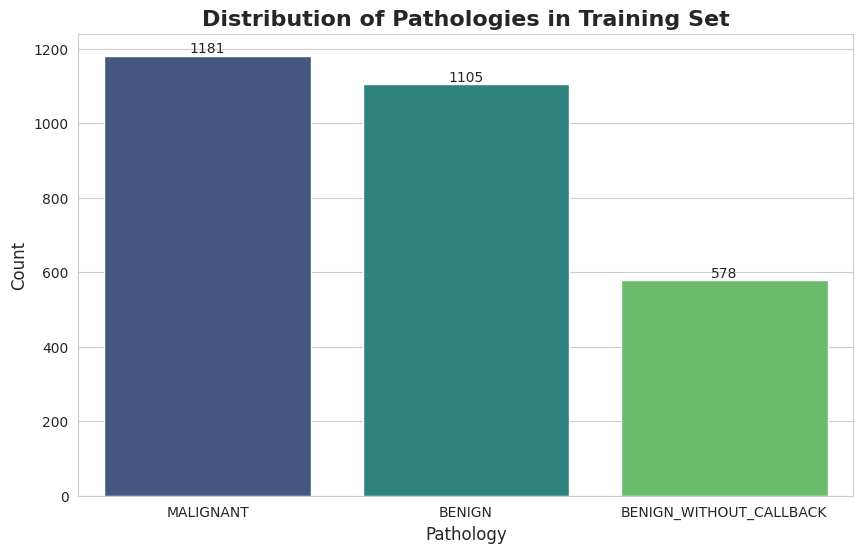

In [4]:
# Step 3.2: Visualize Pathology Distribution

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.countplot(data=combined_df, x='pathology', order=combined_df["pathology"].value_counts().index, palette="viridis")

plt.title("Distribution of Pathologies in Training Set", fontsize=16, fontweight='bold')
plt.xlabel("Pathology", fontsize=12)
plt.ylabel("Count", fontsize=12)
for bar in ax.containers:
    ax.bar_label(bar)
plt.show()

### Data Counts
- **Malignant:** 1,181 cases  
- **Benign:** 1,105 cases  
- **Benign (No Callback):** 578 cases  
**Grouped:** 1,683 benign vs. 1,181 malignant (~1.4:1 ratio)

---

### Key Findings
- **Case-Level Imbalance:** Slight skew towards benign, may bias the model.  
- **Pixel-Level Imbalance:** Lesion pixels are tiny compared to background pixels—much harder problem.

---

### Implications
- ✅ Use **Dice Loss** → handles pixel imbalance by focusing on spatial overlap.  
- ✅ Use **Focal Loss** → emphasizes harder malignant cases.  
- ⭐ **Best approach:** a **combined loss** that balances both issues.


## 4. Data Preprocessing and Pipeline

In [5]:
# Step 4.1: Build the Cropped ROI Data Master List (with Patient ID)
print("\nBuilding Cropped ROI Dataset")

def build_and_check_cropped_path(relative_dicom_path, jpeg_base_dir):
    """
    Build path for CROPPED images (ROI), not full mammograms
    """
    try:
        path_parts = relative_dicom_path.split("/")
        uid1 = path_parts[1]
        uid2 = path_parts[2]

        possible_folder_path1 = os.path.join(jpeg_base_dir, uid1)
        possible_folder_path2 = os.path.join(jpeg_base_dir, uid2)

        folder_path = None
        if os.path.isdir(possible_folder_path1):
            folder_path = possible_folder_path1
        elif os.path.isdir(possible_folder_path2):
            folder_path = possible_folder_path2

        if folder_path:
            image_files = glob.glob(os.path.join(folder_path, "*CROP*.jpg")) + \
                         glob.glob(os.path.join(folder_path, "*ROI*.jpg")) + \
                         glob.glob(os.path.join(folder_path, "*CROP*.png")) + \
                         glob.glob(os.path.join(folder_path, "*ROI*.png"))
            if not image_files:
                image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                             glob.glob(os.path.join(folder_path, "*.png"))
            if image_files:
                return image_files[0]
    except (IndexError, TypeError):
        return None
    return None

# Define Input Files
input_csv_files = [
    os.path.join(CSV_FOLDER_PATH, "mass_case_description_train_set.csv"),
    os.path.join(CSV_FOLDER_PATH, "calc_case_description_train_set.csv")
]

print(f"Processing files: {[os.path.basename(f) for f in input_csv_files]}") # Debugging line to check file names
print(f"Output file: {MASTER_LIST_PATH}")
print("-"*60)

found_pairs_count = 0
with open(MASTER_LIST_PATH, 'w', newline='') as outfile:
    csv_writer = csv.writer(outfile)
    csv_writer.writerow(['cropped_image_path', 'roi_mask_path', 'pathology', 'assessment', 'patient_id'])

    for filepath in input_csv_files:
        print(f"Processing: {os.path.basename(filepath)}")
        with open(filepath, "r") as infile:
            csv_reader = csv.reader(infile)
            header = next(csv_reader)

            try:
                crop_path_idx = header.index('cropped image file path')
                mask_path_idx = header.index('ROI mask file path')
                pathology_idx = header.index('pathology')
                assessment_idx = header.index('assessment')
                patient_id_idx = header.index('patient_id')

            except ValueError as e:
                print(f"Error: Missing required columns in {os.path.basename(filepath)}: {e}")
                continue

            for row in tqdm(csv_reader):
                relative_crop_path = row[crop_path_idx]
                relative_mask_path = row[mask_path_idx]
                pathology = row[pathology_idx]
                assessment = row[assessment_idx]
                patient_id = row[patient_id_idx]

                full_crop_path = build_and_check_cropped_path(relative_crop_path, IMAGE_FOLDER_PATH)
                full_mask_path = build_and_check_cropped_path(relative_mask_path, IMAGE_FOLDER_PATH)

                if full_crop_path and full_mask_path:
                    csv_writer.writerow([full_crop_path, full_mask_path, pathology, assessment, patient_id])
                    found_pairs_count += 1

print(f"\n Step 4.1: Completed: Found {found_pairs_count} valid cropped ROI pairs with Patient IDs")


Building Cropped ROI Dataset
Processing files: ['mass_case_description_train_set.csv', 'calc_case_description_train_set.csv']
Output file: /kaggle/working/cropped_master_list.csv
------------------------------------------------------------
Processing: mass_case_description_train_set.csv


1318it [00:14, 91.58it/s]


Processing: calc_case_description_train_set.csv


1546it [00:15, 97.10it/s] 


 Step 4.1: Completed: Found 2863 valid cropped ROI pairs with Patient IDs


In [6]:
# Step 4.2: Leak-Proof Patient-Aware Splitting and Dataset Creation

# 1. Load the master list which now includes patient IDs
df_master = pd.read_csv(MASTER_LIST_PATH)

# 2. Get unique list of patient IDs and split them for training and validation
unique_patients = df_master["patient_id"].unique()
train_patients, val_patients = train_test_split(
    unique_patients,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_SEED
)

print(f"Splitting {len(unique_patients)} unique patients: {len(train_patients)} for training, {len(val_patients)} for validation.")

# 3. Create training and validation DataFrames based by filtering the master list
train_df = df_master[df_master['patient_id'].isin(train_patients)].reset_index(drop=True)
val_df = df_master[df_master['patient_id'].isin(val_patients)].reset_index(drop=True)

# Data Augmentation Strategy
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GridDistortion(p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 4. Define the PyTorch Dataset class
class MammographyDataset(Dataset):
    """Dataset for cropped ROI mammography images"""
    def __init__(self, dataframe, transforms=None):
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["cropped_image_path"]
        mask_path = row["roi_mask_path"]

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None: image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
        if mask is None: mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask.astype(np.float32) / 255.0

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        mask = mask.unsqueeze(0)
        return image, mask
    

# 5. Create the final, leak-proof dataset and dataloader objects
train_dataset = MammographyDataset(dataframe=train_df, transforms=train_transforms)
val_dataset = MammographyDataset(dataframe=val_df, transforms=val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nLeak-proof dataset Statistics:")
print(f"Training Samples (images): {len(train_dataset)}")
print(f"Validation Samples (images): {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Step 4.2: Completed: DataLoaders created (Leak-proof)")

Splitting 1248 unique patients: 998 for training, 250 for validation.

Leak-proof dataset Statistics:
Training Samples (images): 2288
Validation Samples (images): 575
Training batches: 286
Validation batches: 72
Step 4.2: Completed: DataLoaders created (Leak-proof)


## 5. Model Architecture: DSU-Net

In [7]:
# Step 5.1: Implement DSU-Net Architecture Components

class DenseBlock(nn.Module):
    """Dense Block implementation inspired by DenseNet"""
    def __init__(self, in_channels, growth_rate=32, num_layers=4):
        super(DenseBlock, self).__init__()
        self.layers=nn.ModuleList()
        for i in range(num_layers):
            layer = self._make_dense_layer(in_channels + i * growth_rate, growth_rate)
            self.layers.append(layer)
        
    def _make_dense_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels), nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate * 4, kernel_size=1, bias=False),
            nn.BatchNorm2d(growth_rate * 4), nn.ReLU(inplace=True),
            nn.Conv2d(growth_rate * 4, growth_rate, kernel_size=3, padding=1, bias=False)
        )
    def forward(self, x):
        features = [x]
        for layer in self.layers:
            combined_input = torch.cat(features, dim=1)
            new_features = layer(combined_input)
            features.append(new_features)
        return torch.cat(features, dim=1)

class AttentionBlock(nn.Module):
    """Attention mechanism for U-Net"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi
    
class DSUNet(nn.Module):
    """DSU-Net architecture with Dense Blocks and Attention"""
    def __init__(self, in_channels=3, n_classes=1, base_filters=64):
        super(DSUNet, self).__init__()

        def _make_encoder_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        def _make_decoder_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        
        self.enc1 = _make_encoder_block(in_channels, base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = _make_encoder_block(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = _make_encoder_block(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = _make_encoder_block(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DenseBlock(base_filters * 8, growth_rate=32, num_layers=6)
        bottleneck_out_channels = base_filters * 8 + 32 * 6

        self.up4 = nn.ConvTranspose2d(bottleneck_out_channels, base_filters * 8, 2, stride=2)
        self.att4 = AttentionBlock(base_filters * 8, base_filters * 8, base_filters * 4)
        self.dec4 = _make_decoder_block(base_filters * 16 , base_filters * 8)

        self.up3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, 2, stride=2)
        self.att3 = AttentionBlock(base_filters * 4, base_filters * 4, base_filters * 2)
        self.dec3 = _make_decoder_block(base_filters * 8, base_filters * 4)

        self.up2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, 2, stride=2)
        self.att2 = AttentionBlock(base_filters * 2, base_filters * 2, base_filters)
        self.dec2 = _make_decoder_block(base_filters * 4, base_filters * 2)

        self.up1 = nn.ConvTranspose2d(base_filters * 2, base_filters, 2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters // 2)
        self.dec1 = _make_decoder_block(base_filters * 2, base_filters)

        self.final = nn.Conv2d(base_filters, n_classes, kernel_size=1)
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        out = self.final(d1)
        return out

# Create model instance and test
print("Creating DSU-Net model...")
model = DSUNet(in_channels=3, n_classes=1, base_filters=64).to(device)
dummy_input = torch.randn(2, 3, 256, 256).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input)
print(f"✅ DSU-Net test - Input: {dummy_input.shape}, Output: {dummy_output.shape}")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_params:,} trainable parameters.")
print("✅ Step 5.1 Completed: DSU-Net Architecture Implemented")

Creating DSU-Net model...
✅ DSU-Net test - Input: torch.Size([2, 3, 256, 256]), Output: torch.Size([2, 1, 256, 256])
Model has 17,262,253 trainable parameters.
✅ Step 5.1 Completed: DSU-Net Architecture Implemented


## 6. Model Training

In [8]:
# Step 6.1: Define Training Components
print("\n Step 6.1: Implementing Training Components")

# Loss Function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6): super().__init__(); self.smooth = smooth

    def forward(self, inputs, targets):
        input = torch.sigmoid(inputs).view(-1)
        target = targets.view(-1)
        intersection = (input * target).sum()
        dice = (2. * intersection + self.smooth) / (input.sum() + target.sum() + self.smooth)
        return 1 - dice
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    
    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        focal_loss = self.alpha * (1 - torch.exp(-bce)) ** self.gamma * bce
        return focal_loss.mean()
        
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, input, target):
        return 0.5 * self.dice(input, target) + 0.3 * self.focal(input, target) + 0.2 * self.bce(input, target)

# Metrics
def dice_score(preds, targets, thres=0.5):
    with torch.no_grad():
        preds = (torch.sigmoid(preds) > thres).float().view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        return (2. * intersection + 1e-6) / (preds.sum() + targets.sum() + 1e-6)
    
def iou_score(preds, targets, thresh=0.5):
    with torch.no_grad():
        preds = (torch.sigmoid(preds) > thresh).float().view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum() - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    
# Optimizer, Scheduler, and Early Stopping
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=10, verbose=True)

class EarlyStopping:
    def __init__(self, patience=15, verbose=True, delta=0.001):
        self.patience, self.verbose, self.delta = patience, verbose, delta
        self.counter, self.best_score, self.early_stop = 0, None, False
        self.best_model_path = os.path.join(SAVED_MODELS_PATH, "dsu_net_best.pth")

    def __call__(self, val_metric, model):
        if self.best_score is None:
            self.best_score = val_metric
            self.save_checkpoint(model)
        elif val_metric < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_metric
            self.save_checkpoint(model)
            self.counter = 0
        
    def save_checkpoint(self, model):
        if self.verbose: print(f"Validation metric improved to {self.best_score:.4f}. Saving model...")
        torch.save(model.state_dict(), self.best_model_path)

early_stopper = EarlyStopping(patience=15, verbose=True)

# Training Functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0
    progress_bar = tqdm(loader, desc="Training")
    for data, targets in progress_bar:
        data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        dice = dice_score(outputs, targets).item()
        iou = iou_score(outputs, targets).item()
        running_dice += dice
        running_iou += iou

        progress_bar.set_postfix(OrderedDict(Loss=f"{loss.item():.4f}", dice=f"{dice:.4f}", IoU=f"{iou:.4f}"))
    return  running_loss/len(loader), running_dice/len(loader), running_iou/len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validation")
        for data, targets in progress_bar:
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            dice = dice_score(outputs, targets).item()
            iou = iou_score(outputs, targets).item()
            running_dice += dice
            running_iou += iou

            progress_bar.set_postfix(OrderedDict(Loss=f"{loss.item():.4f}", Dice=f"{dice:.4f}", IoU=f"{iou:.4f}"))
    return running_loss/len(loader), running_dice/len(loader), running_iou/len(loader)
print("✅ Step 6.1 Completed: Training Components Implemented")


 Step 6.1: Implementing Training Components
✅ Step 6.1 Completed: Training Components Implemented


In [9]:
# Step 6.2: Training Execution
print("\n Starting DSU-Net Training")
print("-"*60)

history = {
    "train_loss": [], "val_loss": [], "train_dice": [], "val_dice": [], "train_iou": [], "val_iou": [], "lr": []
}

best_val_dice = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-"*50)

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice, val_iou = validate_one_epoch(model, val_loader, criterion, device)

    scheduler.step(val_dice)

    history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
    history["train_dice"].append(train_dice); history["val_dice"].append(val_dice)
    history["train_iou"].append(train_iou); history["val_iou"].append(val_iou)
    history["lr"].append(optimizer.param_groups[0]['lr'])

    if val_dice > best_val_dice: best_val_dice = val_dice

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train - Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"Val - Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")
    print(f" Best Val Dice Thus Far: {best_val_dice:.4f}")

    early_stopper(val_dice, model)
    if early_stopper.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

print("\nTraining complete.")
print(f"Best Validation Dice Score Achieved: {early_stopper.best_score:.4f}")

# Load the best model for evaluation
print("Loading best model for final evaluation...")
model.load_state_dict(torch.load(early_stopper.best_model_path))
print("✅ Best model loaded successfully.")


 Starting DSU-Net Training
------------------------------------------------------------

Epoch 1/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.42it/s, Loss=0.1508, Dice=0.9709, IoU=0.9434]



Epoch 1 Summary:
Train - Loss: 0.3353 | Dice: 0.7421 | IoU: 0.6151
Val - Loss: 0.2548 | Dice: 0.8973 | IoU: 0.8316
 Best Val Dice Thus Far: 0.8973
Validation metric improved to 0.8973. Saving model...

Epoch 2/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.54it/s, Loss=0.1247, Dice=0.9774, IoU=0.9557]



Epoch 2 Summary:
Train - Loss: 0.2944 | Dice: 0.7394 | IoU: 0.6199
Val - Loss: 0.2175 | Dice: 0.9114 | IoU: 0.8554
 Best Val Dice Thus Far: 0.9114
Validation metric improved to 0.9114. Saving model...

Epoch 3/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:19<00:00,  3.62it/s, Loss=0.1034, Dice=0.9449, IoU=0.8956]



Epoch 3 Summary:
Train - Loss: 0.2527 | Dice: 0.7788 | IoU: 0.6590
Val - Loss: 0.2052 | Dice: 0.8539 | IoU: 0.7648
 Best Val Dice Thus Far: 0.9114
EarlyStopping counter: 1 out of 15

Epoch 4/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:19<00:00,  3.68it/s, Loss=0.0988, Dice=0.9761, IoU=0.9534]



Epoch 4 Summary:
Train - Loss: 0.2470 | Dice: 0.7718 | IoU: 0.6532
Val - Loss: 0.1722 | Dice: 0.9096 | IoU: 0.8523
 Best Val Dice Thus Far: 0.9114
EarlyStopping counter: 2 out of 15

Epoch 5/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:19<00:00,  3.60it/s, Loss=0.0947, Dice=0.9921, IoU=0.9842]



Epoch 5 Summary:
Train - Loss: 0.2353 | Dice: 0.7833 | IoU: 0.6660
Val - Loss: 0.1578 | Dice: 0.9403 | IoU: 0.9067
 Best Val Dice Thus Far: 0.9403
Validation metric improved to 0.9403. Saving model...

Epoch 6/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:19<00:00,  3.66it/s, Loss=0.0572, Dice=0.9785, IoU=0.9580]



Epoch 6 Summary:
Train - Loss: 0.2344 | Dice: 0.7772 | IoU: 0.6578
Val - Loss: 0.1369 | Dice: 0.9161 | IoU: 0.8635
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 1 out of 15

Epoch 7/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.56it/s, Loss=0.0787, Dice=0.9687, IoU=0.9393]



Epoch 7 Summary:
Train - Loss: 0.2342 | Dice: 0.7678 | IoU: 0.6480
Val - Loss: 0.1313 | Dice: 0.9110 | IoU: 0.8538
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 2 out of 15

Epoch 8/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.49it/s, Loss=0.0911, Dice=0.9892, IoU=0.9787]



Epoch 8 Summary:
Train - Loss: 0.2351 | Dice: 0.7722 | IoU: 0.6560
Val - Loss: 0.1595 | Dice: 0.9343 | IoU: 0.8957
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 3 out of 15

Epoch 9/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.37it/s, Loss=0.0563, Dice=0.9867, IoU=0.9738]



Epoch 9 Summary:
Train - Loss: 0.2285 | Dice: 0.7737 | IoU: 0.6559
Val - Loss: 0.1206 | Dice: 0.9309 | IoU: 0.8897
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 4 out of 15

Epoch 10/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.35it/s, Loss=0.0552, Dice=0.9853, IoU=0.9710]



Epoch 10 Summary:
Train - Loss: 0.2254 | Dice: 0.7805 | IoU: 0.6611
Val - Loss: 0.1419 | Dice: 0.9289 | IoU: 0.8862
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 5 out of 15

Epoch 11/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.33it/s, Loss=0.0701, Dice=0.9759, IoU=0.9530]



Epoch 11 Summary:
Train - Loss: 0.2285 | Dice: 0.7743 | IoU: 0.6572
Val - Loss: 0.1443 | Dice: 0.9138 | IoU: 0.8597
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 6 out of 15

Epoch 12/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:22<00:00,  3.27it/s, Loss=0.0718, Dice=0.9865, IoU=0.9734]



Epoch 12 Summary:
Train - Loss: 0.2179 | Dice: 0.7853 | IoU: 0.6685
Val - Loss: 0.1335 | Dice: 0.9334 | IoU: 0.8936
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 7 out of 15

Epoch 13/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.30it/s, Loss=0.0947, Dice=0.9433, IoU=0.8927]



Epoch 13 Summary:
Train - Loss: 0.2228 | Dice: 0.7794 | IoU: 0.6644
Val - Loss: 0.1510 | Dice: 0.8789 | IoU: 0.8002
 Best Val Dice Thus Far: 0.9403
EarlyStopping counter: 8 out of 15

Epoch 14/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.29it/s, Loss=0.0625, Dice=0.9929, IoU=0.9860]



Epoch 14 Summary:
Train - Loss: 0.2165 | Dice: 0.7866 | IoU: 0.6683
Val - Loss: 0.1260 | Dice: 0.9424 | IoU: 0.9107
 Best Val Dice Thus Far: 0.9424
Validation metric improved to 0.9424. Saving model...

Epoch 15/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.33it/s, Loss=0.0565, Dice=0.9909, IoU=0.9820]



Epoch 15 Summary:
Train - Loss: 0.2160 | Dice: 0.7859 | IoU: 0.6719
Val - Loss: 0.1254 | Dice: 0.9399 | IoU: 0.9061
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 1 out of 15

Epoch 16/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.29it/s, Loss=0.0576, Dice=0.9631, IoU=0.9287]



Epoch 16 Summary:
Train - Loss: 0.2153 | Dice: 0.7901 | IoU: 0.6746
Val - Loss: 0.1447 | Dice: 0.8876 | IoU: 0.8161
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 2 out of 15

Epoch 17/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.31it/s, Loss=0.0841, Dice=0.9767, IoU=0.9545]



Epoch 17 Summary:
Train - Loss: 0.2111 | Dice: 0.7950 | IoU: 0.6793
Val - Loss: 0.1363 | Dice: 0.9208 | IoU: 0.8709
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 3 out of 15

Epoch 18/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.31it/s, Loss=0.0470, Dice=0.9849, IoU=0.9702]



Epoch 18 Summary:
Train - Loss: 0.2106 | Dice: 0.7917 | IoU: 0.6786
Val - Loss: 0.1183 | Dice: 0.9289 | IoU: 0.8861
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 4 out of 15

Epoch 19/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:22<00:00,  3.24it/s, Loss=0.0452, Dice=0.9865, IoU=0.9733]



Epoch 19 Summary:
Train - Loss: 0.2033 | Dice: 0.8039 | IoU: 0.6901
Val - Loss: 0.1187 | Dice: 0.9310 | IoU: 0.8900
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 5 out of 15

Epoch 20/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:22<00:00,  3.26it/s, Loss=0.0562, Dice=0.9855, IoU=0.9715]



Epoch 20 Summary:
Train - Loss: 0.2134 | Dice: 0.7895 | IoU: 0.6774
Val - Loss: 0.1247 | Dice: 0.9249 | IoU: 0.8789
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 6 out of 15

Epoch 21/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.33it/s, Loss=0.0584, Dice=0.9861, IoU=0.9726]



Epoch 21 Summary:
Train - Loss: 0.2137 | Dice: 0.7876 | IoU: 0.6737
Val - Loss: 0.1200 | Dice: 0.9297 | IoU: 0.8870
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 7 out of 15

Epoch 22/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.38it/s, Loss=0.0570, Dice=0.9743, IoU=0.9499]



Epoch 22 Summary:
Train - Loss: 0.1990 | Dice: 0.8081 | IoU: 0.6981
Val - Loss: 0.1310 | Dice: 0.8990 | IoU: 0.8353
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 8 out of 15

Epoch 23/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.35it/s, Loss=0.0554, Dice=0.9787, IoU=0.9582]



Epoch 23 Summary:
Train - Loss: 0.1937 | Dice: 0.8075 | IoU: 0.6975
Val - Loss: 0.1269 | Dice: 0.9047 | IoU: 0.8444
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 9 out of 15

Epoch 24/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:21<00:00,  3.33it/s, Loss=0.0552, Dice=0.9823, IoU=0.9652]



Epoch 24 Summary:
Train - Loss: 0.1987 | Dice: 0.7985 | IoU: 0.6875
Val - Loss: 0.1223 | Dice: 0.9202 | IoU: 0.8711
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 10 out of 15

Epoch 25/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.51it/s, Loss=0.0661, Dice=0.9772, IoU=0.9553]



Epoch 25 Summary:
Train - Loss: 0.2010 | Dice: 0.7973 | IoU: 0.6853
Val - Loss: 0.1405 | Dice: 0.8970 | IoU: 0.8331
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 11 out of 15

Epoch 26/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.50it/s, Loss=0.0647, Dice=0.9762, IoU=0.9535]



Epoch 26 Summary:
Train - Loss: 0.1894 | Dice: 0.8102 | IoU: 0.7007
Val - Loss: 0.1335 | Dice: 0.8897 | IoU: 0.8241
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 12 out of 15

Epoch 27/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.51it/s, Loss=0.0600, Dice=0.9798, IoU=0.9603]



Epoch 27 Summary:
Train - Loss: 0.1855 | Dice: 0.8116 | IoU: 0.7041
Val - Loss: 0.1224 | Dice: 0.9082 | IoU: 0.8510
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 13 out of 15

Epoch 28/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.44it/s, Loss=0.0545, Dice=0.9773, IoU=0.9556]



Epoch 28 Summary:
Train - Loss: 0.1853 | Dice: 0.8154 | IoU: 0.7046
Val - Loss: 0.1187 | Dice: 0.9111 | IoU: 0.8544
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 14 out of 15

Epoch 29/100
--------------------------------------------------


Validation: 100%|██████████| 72/72 [00:20<00:00,  3.52it/s, Loss=0.0608, Dice=0.9863, IoU=0.9730]


Epoch 29 Summary:
Train - Loss: 0.1817 | Dice: 0.8150 | IoU: 0.7077
Val - Loss: 0.1204 | Dice: 0.9220 | IoU: 0.8738
 Best Val Dice Thus Far: 0.9424
EarlyStopping counter: 15 out of 15
Early stopping triggered. Stopping training.

Training complete.
Best Validation Dice Score Achieved: 0.9424
Loading best model for final evaluation...
✅ Best model loaded successfully.


## 7. Evaluation and Results


 Step 7.1: Plotting Final Training Curves


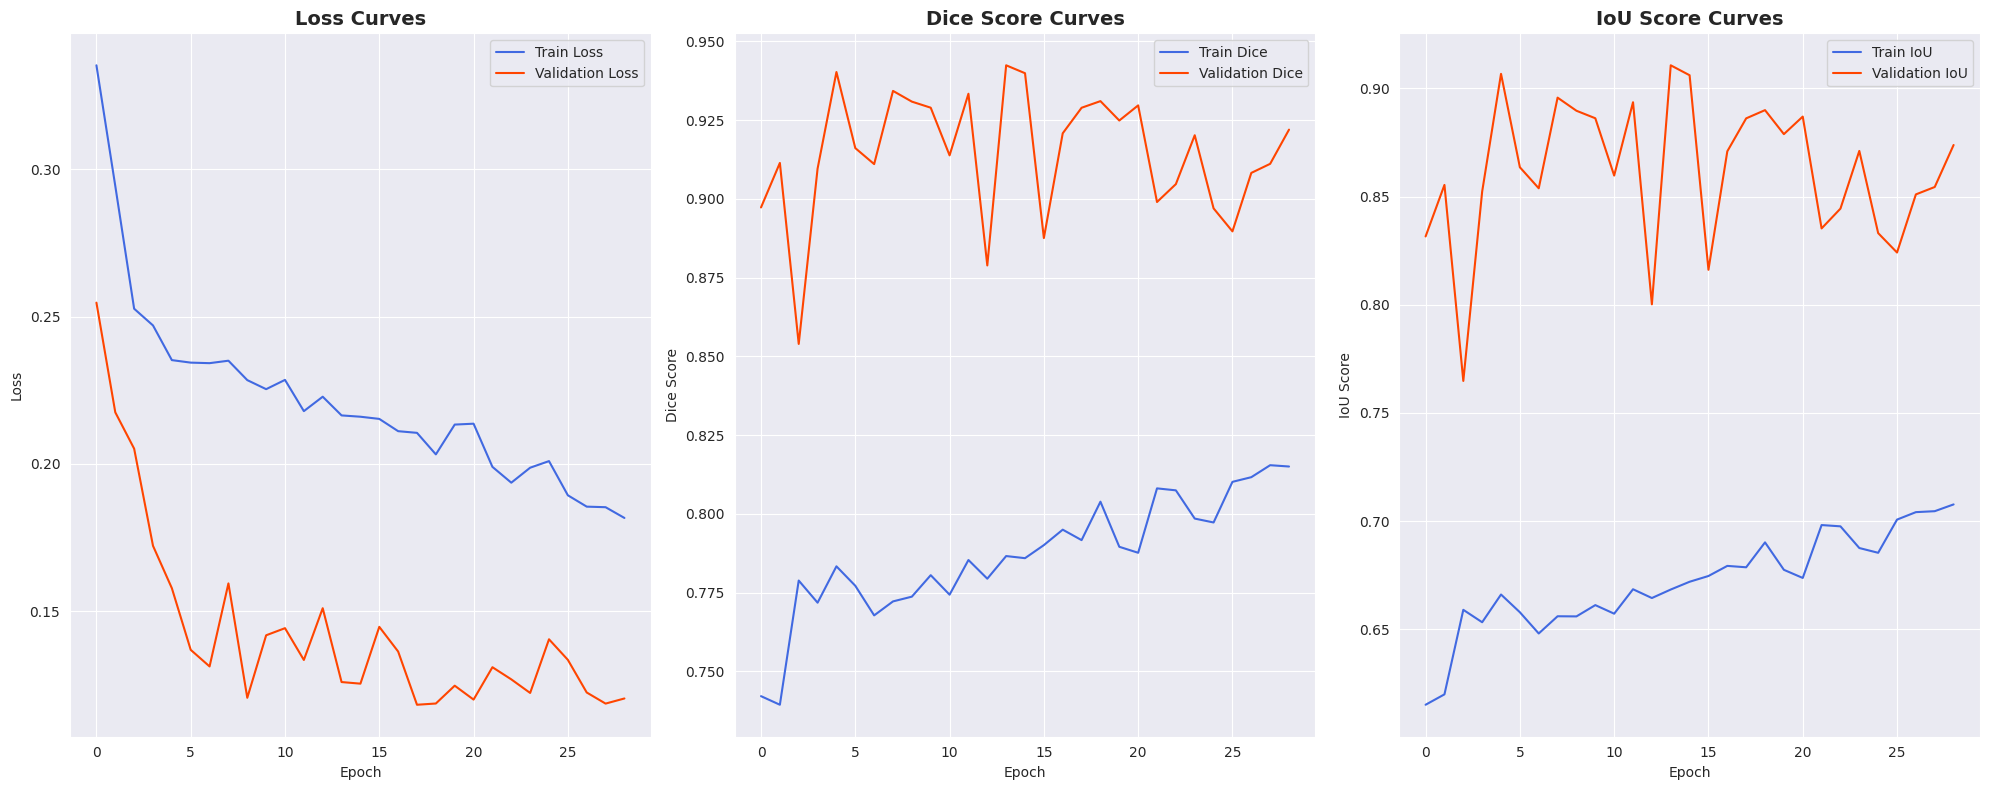

In [10]:
# Step 7.1: Plot Training and Validation Curves
print("\n Step 7.1: Plotting Final Training Curves")

epochs_ran = len(history['train_loss'])
plt.figure(figsize=(20, 8))
sns.set_style("darkgrid")

plt.subplot(1, 3, 1)
plt.plot(range(epochs_ran), history['train_loss'], label='Train Loss', color='royalblue')
plt.plot(range(epochs_ran), history['val_loss'], label='Validation Loss', color='orangered')
plt.title('Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(epochs_ran), history['train_dice'], label='Train Dice', color='royalblue')
plt.plot(range(epochs_ran), history['val_dice'], label='Validation Dice', color='orangered')
plt.title('Dice Score Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch'); plt.ylabel('Dice Score'); plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(epochs_ran), history['train_iou'], label='Train IoU', color='royalblue')
plt.plot(range(epochs_ran), history['val_iou'], label='Validation IoU', color='orangered')
plt.title('IoU Score Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch'); plt.ylabel('IoU Score'); plt.legend()

plt.tight_layout()
plt.show()


🔍 Step 7.2: Visualizing Model Predictions on Validation Set


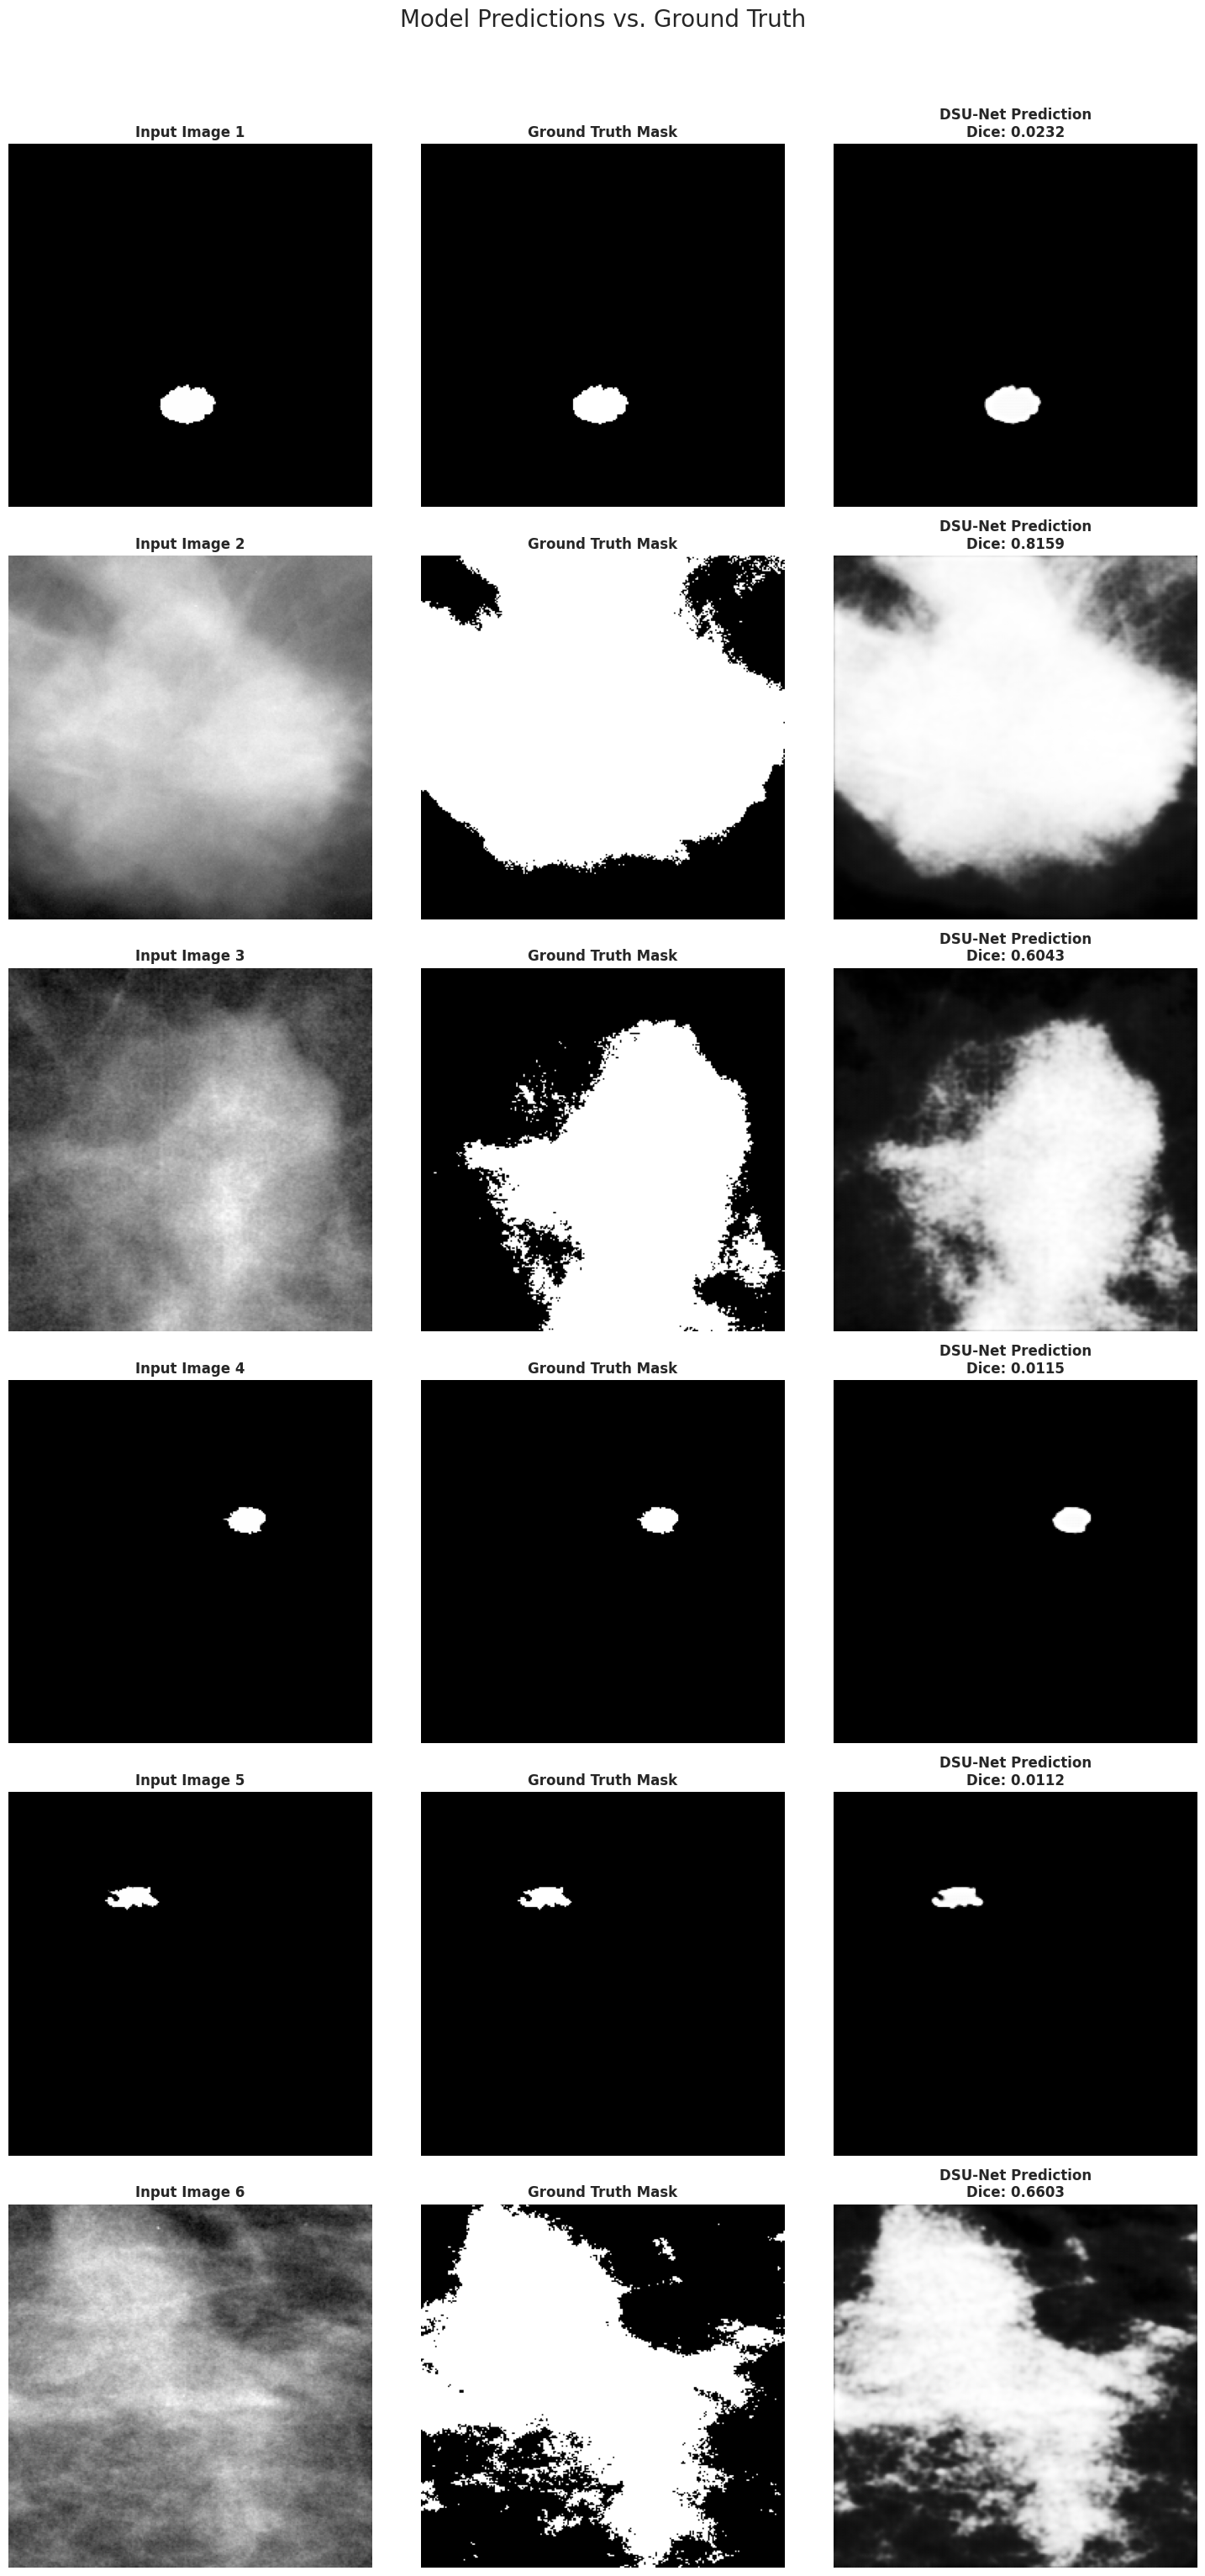

In [11]:
# Step 7.2: Visualize Predictions on Validation Set
print("\n🔍 Step 7.2: Visualizing Model Predictions on Validation Set")

def visualize_predictions(model, loader, device, num_samples=6):
    model.eval()
    images, masks = next(iter(loader))
    
    with torch.no_grad():
        images = images.to(device)
        predictions = torch.sigmoid(model(images)).cpu()
        
    images = images.cpu()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Model Predictions vs. Ground Truth', fontsize=20, y=1.02)
    
    for i in range(min(num_samples, len(images))):
        img_display = images[i].permute(1, 2, 0).numpy()
        img_display = (img_display * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)
        
        mask_display = masks[i].squeeze().numpy()
        pred_display = predictions[i].squeeze().numpy()
        
        dice = dice_score(torch.tensor(pred_display), torch.tensor(mask_display)).item()
        
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Input Image {i+1}', fontweight='bold'); axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_display, cmap='gray')
        axes[i, 1].set_title(f'Ground Truth Mask', fontweight='bold'); axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_display, cmap='gray')
        axes[i, 2].set_title(f'DSU-Net Prediction\nDice: {dice:.4f}', fontweight='bold'); axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device)